### It can be theorised that WTI price is equal to some function f(USD, inflation, storage). So let's first perform a rolling regression on these factors from in order to choose the optimal parameters:

In [1]:
#Importing all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

/Users/arjunkalsi/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### WTI 1 month future prices 2010-2019:

In [2]:
data_prices_crude         = pd.read_excel('PET_PRI_FUT_S1_D.xls', sheet_name = 'Data 1', skiprows = 2)
data_prices_crude.columns = ['Date', 'F1', 'F2', 'F3', 'F4']
data_prices_crude         = data_prices_crude[(data_prices_crude['Date'] >= '2009-08-07') & (data_prices_crude['Date'] <= '2021-12-31')]
data_prices_crude         = data_prices_crude.set_index('Date')
data_prices_crude.drop(columns=['F2','F3','F4'],inplace=True)
data_prices_crude.head(100)

,F1
Date,
2009-08-07,70.93
2009-08-10,70.60
2009-08-11,69.45
2009-08-12,70.16
2009-08-13,70.52
...,...
2009-12-22,74.40
2009-12-23,76.67
2009-12-24,78.05


### 10 year breakeven inflation rate 2010-2019:

In [3]:
inflation_rate         = pd.read_excel('T10YIE.xls', skiprows = 10)
inflation_rate.columns = ['Date','Inflation Rate']
inflation_rate         = inflation_rate[(inflation_rate['Date'] >= '2009-08-12') & (inflation_rate['Date'] <= '2021-12-31')]
inflation_rate         = inflation_rate.set_index('Date')
inflation_rate.head()

,Inflation Rate
Date,
2009-08-12,1.88
2009-08-13,1.79
2009-08-14,1.70
2009-08-17,1.69
2009-08-18,1.73


### Nominal USD Index 2010-2019:

In [4]:
exchange_rate         = pd.read_excel('DTWEXBGS.xls', skiprows = 10)
exchange_rate.columns = ['Date','USD Index']
exchange_rate         = exchange_rate[(exchange_rate['Date'] >= '2009-08-07') & (exchange_rate['Date'] <= '2021-12-31')]
exchange_rate         = exchange_rate.set_index('Date')
exchange_rate.head()

,USD Index
Date,
2009-08-07,94.4692
2009-08-10,94.6087
2009-08-11,94.8678
2009-08-12,94.5394
2009-08-13,94.2392


### Weekly stock data 2010-2019:

In [5]:
data_stocks               = pd.read_excel('PET_STOC_WSTK_DCU_NUS_W.xls', sheet_name = 'Data 1', skiprows = 2)
data_stocks               = data_stocks[['Date', 'Stocks']]
data_stocks               = data_stocks[(data_stocks['Date'] >= '2009-08-07') & (data_stocks['Date'] <= '2021-12-31')]
data_stocks         = data_stocks.set_index('Date')
data_stocks.head(100)

,Stocks
Date,
2009-08-07,1058086
2009-08-14,1049688
2009-08-21,1049816
2009-08-28,1049443
2009-09-04,1043637
...,...
2011-06-03,1073439
2011-06-10,1070033
2011-06-17,1068311


### Merging the data together:

In [6]:
df1 = pd.merge(data_prices_crude,inflation_rate,how = 'left',on='Date')
df1 = pd.merge(df1,exchange_rate,how = 'left',on='Date')
df1 = pd.merge(df1,data_stocks,how = 'left',on='Date')
df1.head()

,F1,Inflation Rate,USD Index,Stocks
Date,,,,
2009-08-07,70.93,NaN,94.4692,1058086.0
2009-08-10,70.60,NaN,94.6087,NaN
2009-08-11,69.45,NaN,94.8678,NaN
2009-08-12,70.16,1.88,94.5394,NaN
2009-08-13,70.52,1.79,94.2392,NaN


### Stock data is weekly so we must use interpolation:

In [7]:
df1['Stocks'].interpolate(inplace=True)
df1 = df1.loc['2009-08-12':]

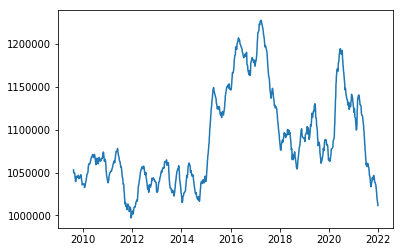

In [8]:
plt.plot(df1['Stocks'])

In [9]:
import pandas_datareader as pdr
import seaborn
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

seaborn.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
%matplotlib inline

### Getting optimal coefficients:

In [10]:
w = 60
endog = df1['F1']
exog = sm.add_constant(df1[['Inflation Rate','USD Index','Stocks']])
rols = RollingOLS(endog, exog, window=w)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)
params

,const,Inflation Rate,USD Index,Stocks
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
...,...,...,...,...
3118,-228.150461,20.315538,-0.470935,0.000297
3119,-187.728962,21.927039,-0.507664,0.000258
3120,-150.824993,23.830340,-0.550962,0.000223
3121,-117.391030,26.261025,-0.606247,0.000191


In [ ]:
params['Date'] = df1.index
params = params.set_index('Date')
params.tail()

### Merging with WTI dataframe:

In [ ]:
df1_reg = pd.merge(df1,params,how = 'left',on='Date')

In [ ]:
df1_regrange = df1_reg.loc['2010-01-04':]
df1_regrange

In [ ]:
df1_regrange['Predicted F1'] = df1_regrange['const'] + (df1_regrange['Inflation Rate_y']*df1_regrange['Inflation Rate_x']) + (df1_regrange['USD Index_y']*df1_regrange['USD Index_x']) + (df1_regrange['Stocks_y']*df1_regrange['Stocks_x'])
df1_regrange


### Plotting F1 against Predicted F1:

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df1_regrange['F1'],label='F1')
plt.plot(df1_regrange['Predicted F1'],label='Predicted F1')
plt.legend()
plt.savefig('F1 versus Predicted F1 (window = 60).png')
plt.show()

In [ ]:
df1_regrange['F1 - Predicted'] = df1_regrange['F1'] - df1_regrange['Predicted F1']
df1_regrange

### Now let's read in the WTI data with the roll implemented from the first assignment:

In [ ]:
#Reading in the files
df_wti           = pd.read_excel('HW3input.xlsx', sheet_name = 'WTI')

#transaction cost
t = 0.01

In [ ]:
df_wti = df_wti.set_index('Date')
df_wti = df_wti.loc['2010-01-04':]
df_wti['F1 - Predicted'] = df1_regrange['F1 - Predicted']
df_wti

### Implementing our strategy and calculating all the necessary values:

In [ ]:
df_wti['C(0)']  = 0.0

epsilon = 0

for i in range(len(df_wti)):
    if df_wti['F1 - Predicted'][i] > epsilon:
        df_wti['C(0)'][i] = -1.0
    elif df_wti['F1 - Predicted'][i] < epsilon:
        df_wti['C(0)'][i] = 1.0

In [ ]:
df_wti['P/L'] = 0.0

for i in range(1,len(df_wti)):
    df_wti['P/L'][i] = df_wti['Cumulative_P/L_barrel'][i]-df_wti['Cumulative_P/L_barrel'][i-1]

In [ ]:
df_wti['P/L_short'] = -df_wti['P/L']

# have to reverse the transaction costs for the roll
for i in range(1,len(df_wti)):
    if df_wti['Holding_type'][i] == 1 and df_wti['Holding_type'][i-1] == 0:
        df_wti['P/L_short'][i-1] = df_wti['P/L_short'][i-1] - 0.04

In [ ]:
df_wti.tail()

In [ ]:
df_wti['P/L_C(0)'] = 0.0
df_wti['Cumulative_P/L_C(0)'] = 0.0

# deciding whether your P&L is from the long or short position
for i in range(1,len(df_wti)):
    if (df_wti['C(0)'][i-1] == 1):
        df_wti['P/L_C(0)'][i] = df_wti['P/L'][i]
        
    if (df_wti['C(0)'][i-1] == -1):
        df_wti['P/L_C(0)'][i] = df_wti['P/L_short'][i]
    

# if it is time to switch positions you have to add the transaction costs
for i in range(1,len(df_wti)):
    if df_wti['C(0)'][i] != df_wti['C(0)'][i-1]:
        df_wti['P/L_C(0)'][i] -= 0.02

# calculating cumulative P&L
for i in range(1,len(df_wti)):
    df_wti['Cumulative_P/L_C(0)'][i] = df_wti['P/L_C(0)'][i] + df_wti['Cumulative_P/L_C(0)'][i-1]

#just to see the behaviour when the c(0) sign flips. You can see we account for the transaction costs here
df_wti.tail(25)

In [ ]:
df_wti['P(t)_C(0)'] = 0.0

for i in range(1,len(df_wti)):
    df_wti['P(t)_C(0)'][i] = df_wti['P(t)_C(0)'][i-1] +(df_wti['P/L_C(0)'][i]*100000)
    
df_wti.tail(2)

In [ ]:
df_wti['dF(t)_C(0)'] = df_wti['P/L_C(0)']*100000

### Calculating performance metrics:

In [ ]:
N = 12

ann_PL_C = df_wti['P(t)_C(0)'][-1]/N

print(f"C(0) Average Annual P&L: {ann_PL_C}")

In [ ]:
ann_SR_C = ann_PL_C/(np.std(df_wti['dF(t)_C(0)'])*np.sqrt(250))

print(f"C(0) Annualised Sharpe Ratio: {ann_SR_C}")

In [ ]:
df_wti['HWM_C(0)'] = 0.0
df_wti['DD_C(0)'] = 0.0

for i in range(len(df_wti)):
    df_wti['HWM_C(0)'][i] = np.max(df_wti['P(t)_C(0)'][0:i+1])
    
    df_wti['DD_C(0)'][i] = df_wti['HWM_C(0)'][i] - df_wti['P(t)_C(0)'][i]


In [ ]:
mdd_C = np.max(df_wti['DD_C(0)'])
mdd_Cdate = df_wti['DD_C(0)'].idxmax()

print(f"C(0) Maximum Drawdown: {mdd_C} at {mdd_Cdate}")

### Graphing the equity line:

In [ ]:
import seaborn as sns
sns.set()

plt.figure(figsize=(10, 6), dpi=80)
plt.ticklabel_format(style='plain')
plt.plot(df_wti.index, df_wti['P(t)_C(0)'], label = 'C(0) Equity Line')
plt.plot(df_wti.index, -df_wti['DD_C(0)'], label = 'C(0) Drawdown',alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('equity line and drawdown not optpitmized')
plt.show()

### Now let's try to find the optimal parameters for the strategy. First let's find the optimal value for w, which is the rolling window value for the rolling regression calculation:

In [ ]:
ws = np.arange(11,70,1)

SRoptimal = 0.0
Wopt = 0.0
epsilon = 0

for w in ws:
    print(w,':')
    print('')
    endog                          = df1['F1']
    exog                           = sm.add_constant(df1[['Inflation Rate','USD Index','Stocks']])
    rols                           = RollingOLS(endog, exog, window=w,min_nobs=10)
    rres                           = rols.fit()
    params                         = rres.params.copy()
    params.index                   = np.arange(1, params.shape[0] + 1)
    
    params['Date']                 = df1.index
    params                         = params.set_index('Date')
    
    df1_reg                        = pd.merge(df1,params,how = 'left',on='Date')
    
    df1_regrange                   = df1_reg.loc['2010-01-04':]
    df1_regrange['Predicted F1']   = df1_regrange['const'] + (df1_regrange['Inflation Rate_y']*df1_regrange['Inflation Rate_x']) + (df1_regrange['USD Index_y']*df1_regrange['USD Index_x']) + (df1_regrange['Stocks_y']*df1_regrange['Stocks_x'])
    
    df1_regrange['F1 - Predicted'] = df1_regrange['F1'] - df1_regrange['Predicted F1']
    df_wti['F1 - Predicted']       = df1_regrange['F1 - Predicted']
    
    df_wti['C(0)']  = 0.0
    for i in range(len(df_wti)):
        if df_wti['F1 - Predicted'][i] > epsilon:
            df_wti['C(0)'][i] = -1.0
        elif df_wti['F1 - Predicted'][i] < epsilon:
            df_wti['C(0)'][i] = 1.0
            
    df_wti['P/L_C(0)'] = 0.0
    df_wti['Cumulative_P/L_C(0)'] = 0.0

    # deciding whether your P&L is from the long or short position
    for i in range(1,len(df_wti)):
        if (df_wti['C(0)'][i-1] == 1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L'][i]
        
        if (df_wti['C(0)'][i-1] == -1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L_short'][i]
    

    # if it is time to switch positions you have to add the transaction costs
    for i in range(1,len(df_wti)):
        if df_wti['C(0)'][i] != df_wti['C(0)'][i-1]:
            df_wti['P/L_C(0)'][i] -= 0.02

    # calculating cumulative P&L
    for i in range(1,len(df_wti)):
        df_wti['Cumulative_P/L_C(0)'][i] = df_wti['P/L_C(0)'][i] + df_wti['Cumulative_P/L_C(0)'][i-1]
        
    df_wti['P(t)_C(0)'] = 0.0

    for i in range(1,len(df_wti)):
        df_wti['P(t)_C(0)'][i] = df_wti['P(t)_C(0)'][i-1] +(df_wti['P/L_C(0)'][i]*100000)
    
    df_wti['dF(t)_C(0)'] = df_wti['P/L_C(0)']*100000
    
    ann_PL_C = df_wti['P(t)_C(0)'][-1]/N
    print(f"C(0) Average Annual P&L: {ann_PL_C}")
    
    ann_SR_C = ann_PL_C/(np.std(df_wti['dF(t)_C(0)'])*np.sqrt(250))
    print(f"C(0) Annualised Sharpe Ratio: {ann_SR_C}")
    
    df_wti['HWM_C(0)'] = 0.0
    df_wti['DD_C(0)'] = 0.0

    for i in range(len(df_wti)):
        df_wti['HWM_C(0)'][i] = np.max(df_wti['P(t)_C(0)'][0:i+1])
        df_wti['DD_C(0)'][i] = df_wti['HWM_C(0)'][i] - df_wti['P(t)_C(0)'][i]
        
    mdd_C = np.max(df_wti['DD_C(0)'])
    mdd_Cdate = df_wti['DD_C(0)'].idxmax()

    print(f"C(0) Maximum Drawdown: {mdd_C} at {mdd_Cdate}")
    
    if ann_SR_C > SRoptimal:
        SRoptimal = ann_SR_C
        Wopt = w

In [ ]:
print(SRoptimal)
print(Wopt)

### Thus the optimal rolling regression parameter is w=50, giving a Sharpe Ratio of 0.42 (epsilon=0)

### Run these cells again:

In [ ]:
w = 50
endog = df1['F1']
exog = sm.add_constant(df1[['Inflation Rate','USD Index','Stocks']])
rols = RollingOLS(endog, exog, window=w)
rres = rols.fit()
params = rres.params.copy()
params.index = np.arange(1, params.shape[0] + 1)

In [ ]:
params['Date'] = df1.index
params = params.set_index('Date')

In [ ]:
df1_reg = pd.merge(df1,params,how = 'left',on='Date')

In [ ]:
df1_regrange = df1_reg.loc['2010-01-04':]

In [ ]:
df1_regrange['Predicted F1'] = df1_regrange['const'] + (df1_regrange['Inflation Rate_y']*df1_regrange['Inflation Rate_x']) + (df1_regrange['USD Index_y']*df1_regrange['USD Index_x']) + (df1_regrange['Stocks_y']*df1_regrange['Stocks_x'])

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df1_regrange['F1'],label='F1')
plt.plot(df1_regrange['Predicted F1'],label='Predicted F1')
plt.legend()
plt.savefig('F1 versus Predicted F1 (opt window=50)')
plt.show()

In [ ]:
df1_regrange['F1 - Predicted'] = df1_regrange['F1'] - df1_regrange['Predicted F1']

In [ ]:
#Reading in the files
df_wti           = pd.read_excel('HW3input.xlsx', sheet_name = 'WTI')

#transaction cost
t = 0.01

In [ ]:
df_wti = df_wti.set_index('Date')
df_wti = df_wti.loc['2010-01-04':]
df_wti['F1 - Predicted'] = df1_regrange['F1 - Predicted']

In [ ]:
df_wti['P/L'] = 0.0

for i in range(1,len(df_wti)):
    df_wti['P/L'][i] = df_wti['Cumulative_P/L_barrel'][i]-df_wti['Cumulative_P/L_barrel'][i-1]

In [ ]:
df_wti['P/L_short'] = -df_wti['P/L']

# have to reverse the transaction costs for the roll
for i in range(1,len(df_wti)):
    if df_wti['Holding_type'][i] == 1 and df_wti['Holding_type'][i-1] == 0:
        df_wti['P/L_short'][i-1] = df_wti['P/L_short'][i-1] - 0.04

### Now let's optimise epsilon, which is the parameter used in our strategy function:

In [ ]:
epsilons = np.arange(0.0,1.01,0.01)
SRoptimal = 0.0
Eopt = 0.0

for epsilon in epsilons:
    print(epsilon,":")
    print("")
    
    df_wti['C(0)']  = 0.0
    for i in range(len(df_wti)):
        if df_wti['F1 - Predicted'][i] > epsilon:
            df_wti['C(0)'][i] = -1.0
        elif df_wti['F1 - Predicted'][i] < epsilon:
            df_wti['C(0)'][i] = 1.0
            
    df_wti['P/L_C(0)'] = 0.0
    df_wti['Cumulative_P/L_C(0)'] = 0.0

    # deciding whether your P&L is from the long or short position
    for i in range(1,len(df_wti)):
        if (df_wti['C(0)'][i-1] == 1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L'][i]
        
        if (df_wti['C(0)'][i-1] == -1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L_short'][i]
    

    # if it is time to switch positions you have to add the transaction costs
    for i in range(1,len(df_wti)):
        if df_wti['C(0)'][i] != df_wti['C(0)'][i-1]:
            df_wti['P/L_C(0)'][i] -= 0.02

    # calculating cumulative P&L
    for i in range(1,len(df_wti)):
        df_wti['Cumulative_P/L_C(0)'][i] = df_wti['P/L_C(0)'][i] + df_wti['Cumulative_P/L_C(0)'][i-1]
        
    df_wti['P(t)_C(0)'] = 0.0

    for i in range(1,len(df_wti)):
        df_wti['P(t)_C(0)'][i] = df_wti['P(t)_C(0)'][i-1] +(df_wti['P/L_C(0)'][i]*100000)
    
    df_wti['dF(t)_C(0)'] = df_wti['P/L_C(0)']*100000
    
    ann_PL_C = df_wti['P(t)_C(0)'][-1]/N
    print(f"C({epsilon}) Average Annual P&L: {ann_PL_C}")
    
    ann_SR_C = ann_PL_C/(np.std(df_wti['dF(t)_C(0)'])*np.sqrt(250))
    print(f"C({epsilon}) Annualised Sharpe Ratio: {ann_SR_C}")
    
    df_wti['HWM_C(0)'] = 0.0
    df_wti['DD_C(0)'] = 0.0

    for i in range(len(df_wti)):
        df_wti['HWM_C(0)'][i] = np.max(df_wti['P(t)_C(0)'][0:i+1])
        df_wti['DD_C(0)'][i] = df_wti['HWM_C(0)'][i] - df_wti['P(t)_C(0)'][i]
        
    mdd_C = np.max(df_wti['DD_C(0)'])
    mdd_Cdate = df_wti['DD_C(0)'].idxmax()

    print(f"C({epsilon}) Maximum Drawdown: {mdd_C} at {mdd_Cdate}")
    print("")
    
    if ann_SR_C > SRoptimal:
        SRoptimal = ann_SR_C
        Eopt = epsilon


In [ ]:
print(f'Best Sharpe Ratio: {SRoptimal}, Best epsilon: {Eopt}')

### Thus the optimal Sharpe Ratio is 0.42 when $\epsilon = 0$. Let's experiment with higher values of $\epsilon$:

In [ ]:
epsilons = [10,9,8,7,6,5,4,3,2,0]
SRoptimal = 0.0
Eopt = 0.0

for epsilon in epsilons:
    print(epsilon,":")
    print("")
    
    df_wti['C(0)']  = 0.0
    for i in range(len(df_wti)):
        if df_wti['F1 - Predicted'][i] > epsilon:
            df_wti['C(0)'][i] = -1.0
        elif df_wti['F1 - Predicted'][i] < epsilon:
            df_wti['C(0)'][i] = 1.0
            
    df_wti['P/L_C(0)'] = 0.0
    df_wti['Cumulative_P/L_C(0)'] = 0.0

    # deciding whether your P&L is from the long or short position
    for i in range(1,len(df_wti)):
        if (df_wti['C(0)'][i-1] == 1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L'][i]
        
        if (df_wti['C(0)'][i-1] == -1):
            df_wti['P/L_C(0)'][i] = df_wti['P/L_short'][i]
    

    # if it is time to switch positions you have to add the transaction costs
    for i in range(1,len(df_wti)):
        if df_wti['C(0)'][i] != df_wti['C(0)'][i-1]:
            df_wti['P/L_C(0)'][i] -= 0.02

    # calculating cumulative P&L
    for i in range(1,len(df_wti)):
        df_wti['Cumulative_P/L_C(0)'][i] = df_wti['P/L_C(0)'][i] + df_wti['Cumulative_P/L_C(0)'][i-1]
        
    df_wti['P(t)_C(0)'] = 0.0

    for i in range(1,len(df_wti)):
        df_wti['P(t)_C(0)'][i] = df_wti['P(t)_C(0)'][i-1] +(df_wti['P/L_C(0)'][i]*100000)
    
    df_wti['dF(t)_C(0)'] = df_wti['P/L_C(0)']*100000
    
    ann_PL_C = df_wti['P(t)_C(0)'][-1]/N
    print(f"C({epsilon}) Average Annual P&L: {ann_PL_C}")
    
    ann_SR_C = ann_PL_C/(np.std(df_wti['dF(t)_C(0)'])*np.sqrt(250))
    print(f"C({epsilon}) Annualised Sharpe Ratio: {ann_SR_C}")
    
    df_wti['HWM_C(0)'] = 0.0
    df_wti['DD_C(0)'] = 0.0

    for i in range(len(df_wti)):
        df_wti['HWM_C(0)'][i] = np.max(df_wti['P(t)_C(0)'][0:i+1])
        df_wti['DD_C(0)'][i] = df_wti['HWM_C(0)'][i] - df_wti['P(t)_C(0)'][i]
        
    mdd_C = np.max(df_wti['DD_C(0)'])
    mdd_Cdate = df_wti['DD_C(0)'].idxmax()

    print(f"C({epsilon}) Maximum Drawdown: {mdd_C} at {mdd_Cdate}")
    print("")
    
    if ann_SR_C > SRoptimal:
        SRoptimal = ann_SR_C
        Eopt = epsilon

### So $\epsilon = 0$, $w = 50$ is the optimal pairing here. Our final results are:

- C(0) Average Annual P&L: 909333.3333333308
- C(0) Annualised Sharpe Ratio: 0.42060292596024096
- C(0) Maximum Drawdown: 5717000.000000048 at 2021-11-01 00:00:00

### Let's finally see the tail end of the dataframe and also graph the equity line for these optimal parameters:

In [ ]:
df_wti.tail()

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.ticklabel_format(style='plain')
plt.plot(df_wti.index, df_wti['P(t)_C(0)'], label = 'C(0) Equity Line')
plt.plot(df_wti.index, -df_wti['DD_C(0)'], label = 'C(0) Drawdown',alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('equity line and drawdown optimized')
plt.show()

### Let s downdload the data in an excel file

In [ ]:
# determining the name of the file
file_name = 'model_strategy_Arthur_Arjun.xlsx'
  
# saving the excel
df_wti.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

### On top of this, and in light of the current political landscape, we also thought it would be interesting to add war sentiment into the strategy somehow. So let's first find and import some data to hopefully derive some conclusions on a more complex strategy. The data we will be using is deaths from conflict and terrorism per 100,000 in the Middle East & North Africa:

In [ ]:
data_war         = pd.read_csv('deaths-conflict-terrorism-per-100000.csv')
data_war         = data_war[data_war['Entity'] == 'Middle East & North Africa']
data_war         = data_war[['Year','Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Rate)']]
data_war.rename(columns={"Year": "Date", "Deaths - Conflict and terrorism - Sex: Both - Age: All Ages (Rate)": "Deaths"},inplace=True)
data_war         = data_war.set_index('Date')
data_war.index   = pd.to_datetime(data_war.index,format='%Y')
data_war         = data_war[(data_war.index >= '2010-01-01') & (data_war.index <= '2021-01-01')]
data_war.head(15)

In [ ]:
df_wti2       = df_wti
wti_war = df_wti2.merge(data_war,how='outer',left_index=True,right_index=True)
wti_war

### Interpolate the death count:

In [ ]:
wti_war['Deaths'].interpolate(inplace=True)
wti_war = wti_war.loc['2010-01-04':'2019-12-31']
wti_war

In [ ]:
wti_war['Deaths'].dtypes

In [ ]:
plt.plot(wti_war['Deaths'])

### The strategy is to hold nothing when the deaths are above the threshold. We initially did this with no time lag  we decided to add a time lag of approximately 1 year as acts of war and terror usually occur in succession:

In [ ]:
wti_war.dropna(inplace=True)
thresholds = [25.0,24.0,23.0,22.0,21.0]
SRoptimal = 0.0
Topt = 0.0
epsilon = 0

for t in thresholds:
    print(t,":")
    print("")
    
    wti_war['C(0)']  = None
    for i in range(len(wti_war)):
        
        if wti_war['C(0)'][i] == 0.0:
            continue
        if wti_war['Deaths'][i] > t:
            wti_war['C(0)'][i+250] = 0.0
            
        if wti_war['F1 - Predicted'][i] > epsilon:
                wti_war['C(0)'][i] = -1.0
        elif wti_war['F1 - Predicted'][i] < epsilon:
                wti_war['C(0)'][i] = 1.0 
                
    wti_war['P/L_C(0)'] = 0.0
    wti_war['Cumulative_P/L_C(0)'] = 0.0

    # deciding whether your P&L is from the long or short position
    for i in range(1,len(wti_war)):
        if (wti_war['C(0)'][i-1] == 0.0):
            wti_war['P/L_C(0)'][i] = 0.0
        
        elif (wti_war['C(0)'][i-1] == 1.0):
            wti_war['P/L_C(0)'][i] = wti_war['P/L'][i]
        
        elif (wti_war['C(0)'][i-1] == -1.0):
            wti_war['P/L_C(0)'][i] = wti_war['P/L_short'][i]
            
    
    # if it is time to switch positions you have to add the transaction costs
    for i in range(1,len(wti_war)):
        if wti_war['C(0)'][i] != wti_war['C(0)'][i-1]:
            wti_war['P/L_C(0)'][i] -= 0.02

    # calculating cumulative P&L
    for i in range(1,len(wti_war)):
        wti_war['Cumulative_P/L_C(0)'][i] = wti_war['P/L_C(0)'][i] + wti_war['Cumulative_P/L_C(0)'][i-1]
        
    wti_war['P(t)_C(0)'] = 0.0

    for i in range(1,len(wti_war)):
        wti_war['P(t)_C(0)'][i] = wti_war['P(t)_C(0)'][i-1] +(wti_war['P/L_C(0)'][i]*100000)
    
    wti_war['dF(t)_C(0)'] = wti_war['P/L_C(0)']*100000
    
    ann_PL_C = wti_war['P(t)_C(0)'][-1]/N
    print(f"C(0) Average Annual P&L: {ann_PL_C}")
    
    ann_SR_C = ann_PL_C/(np.std(wti_war['dF(t)_C(0)'])*np.sqrt(250))
    print(f"C(0) Annualised Sharpe Ratio: {ann_SR_C}")
    
    wti_war['HWM_C(0)'] = 0.0
    wti_war['DD_C(0)'] = 0.0

    for i in range(len(wti_war)):
        wti_war['HWM_C(0)'][i] = np.max(wti_war['P(t)_C(0)'][0:i+1])
        wti_war['DD_C(0)'][i] = wti_war['HWM_C(0)'][i] - wti_war['P(t)_C(0)'][i]
        
    mdd_C = np.max(wti_war['DD_C(0)'])
    mdd_Cdate = wti_war['DD_C(0)'].idxmax()

    print(f"C(0) Maximum Drawdown: {mdd_C} at {mdd_Cdate}")
    print("")
    
    if ann_SR_C > SRoptimal:
        SRoptimal = ann_SR_C
        Topt = t

### Now our optimal results are with a threshold of 21:

- C(0) Average Annual P&L: 1164000.0000000016
- C(0) Annualised Sharpe Ratio: 0.6115587914972023
- C(0) Maximum Drawdown: 3742999.999999998 at 2011-08-09 00:00:00

### Let's also graph the equity line below:

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.ticklabel_format(style='plain')
plt.plot(wti_war.index, wti_war['P(t)_C(0)'], label = 'C(0.01) Equity Line')
plt.plot(wti_war.index, -wti_war['DD_C(0)'], label = 'C(0.01) Drawdown',alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('EL + drawdown and geopolitical risk reduction')
plt.show()

### Although the war-based strategy is obviously not the most robust and may be completely random, we can see that by assigning a threshold to terminate trading we have considerably reduced maximum drawdown and thus reduced risk and improved P&L. We have also improved the Sharpe ratio by so this experiment was surprisingly successful. By sampling over a larger range we may be able to see more reliable patterns, but we may not have spent enough time in a globalising economy to notice patterns/time-lags like these.

In [ ]:
# determining the name of the file
file_name = 'model_strategy_Arthur_Arjun_with_geopolitical_risk_reduction.xlsx'
  
# saving the excel
df_wti.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')